In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-02 13:22:53.474 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]

2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [7]:
import collections
count_labels = collections.Counter([traindataset[i][1] for  i in range(len(traindataset))])
{v: count_labels[v] / len(traindataset) for v in count_labels}
# TODO ~ about 4 lines of code

{'humor': 0.31414510476474533,
 'wiki': 0.31175900380284843,
 'proverbs': 0.06196405935426143,
 'reuters': 0.3121318320781448}

Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

Naar voren komt is dat de dataset ongebalanceerd is. De verdeling van de 4 classes is niet gelijk. Het aantal zinnen met het label 'proverbs' is beduidend lager vergeleken met de andere 3 labels. De kans dat de zin het label 'humor' of 'wiki'of 'reuters' heeft is veel groter. Het model kan hierdoor niet bruikbare features leren van de groep met het label 'proverbs', het model heeft minder voorbeelden ter beschikking om van te leren. Er is hierdoor een vergrote kans van overfitting.      

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [8]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    "A preprocessor with the cast_label function for adding the labels from the dictionary"
    def cast_label(self, label: str) -> int:
        if label in d.keys():
            return d[label]

To test the preprocessor:

In [9]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])

(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [10]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [11]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 36]),
 tensor([1, 2, 1, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2, 1, 1, 2, 3, 3, 1, 1, 2, 0, 2,
         0, 0, 0, 1, 0, 2, 0, 1]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [12]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code

metrics = [metrics.Accuracy()]
loss_fn = torch.nn.CrossEntropyLoss()


Om te controleren of de uitkomst correct is gebruiken we de CrossEntropyloss. Deze is geschikt voor multiclass categorisatie. MSE kan bijvoorbeeld hier niet voor gebruiken aangezien dit juist is voor numerieke voorspellingen. Ik heb later in het notebook de addition metric (metrics = [metrics.Accuracy(), metrics.F1Score()]), omdat ik graag het verschil wil laten in de confusion matrix. 
De f1 score kijkt naar een gemiddele van de precisie en recall ( tussen 0 en 1) scores en kan worden gebruikt voor classificatie problemen. De F1 score kan gebruikt worden in ongebalanceerde datasets. 



## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [13]:

log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3, 
    "dropout": 0.1, 
    "output_size": 4,
}
from src.models import rnn
model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [14]:
len(traindataset)/32 # lengte traindataset gedeeld door de batchsize

419.09375

De lengte van de traindataset is 13.411. Hierbij kun je dus 420 batches maken van 32. 

In [15]:
(len(traindataset) + len(testdataset)) / (32*25) # de totale lengte van de dataset gedeeld door de train step en de batchsize

20.955

De totale dataset heeft een lengte van 16.764. Om de hele datsaet te covereren zijn er 21 epochs nodig. 

In [16]:
len(traindataset) / (32*25) # de totale lengte van de traindataset gedeeld door de train step en de batchsize

16.76375

Om de totale triandatset te coveren zijn er mnimaal 17 epochs nodig op basis van 25 train_steps.  

In [17]:
from src.training import train_model

model = train_model.trainloop(
    epochs=21,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


2022-07-02 13:23:38.132518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 13:23:38.132556: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-02 13:23:40.071 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220702-1323

KeyboardInterrupt



Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

<img src="../figures/tensorboard_nlp.PNG">

In de bovenste twee grafieken van de afbeelding zijn de test en train loss te zien. Deze zijn beide nog vrij hoog en de learning rate blijft stabiel op 1e-3 ondanks dat er een scheduler in de trainloop zit die mogelijk de learning rate kan verlagen. Daarnaast vlakt de accuracy wel iets af, echter is mijn verwachting hierbij dat het aantal epochs aan de lage kant is. 

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

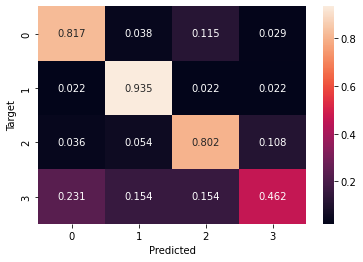

In [34]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

Je ziet hier de uitkomst tussen niet normale verdeling van de dataset. Hierbij is bijvoorbeeld de eerste cel, deze is predicted 0 en voor 80% is deze ook 0. Dit geldt dus niet voor groep 3, waarbij deze maar rond de 45% ook groep 3 voorspelt. Label 3 is de groep 'proverbs, waarbij er een veel lager aantal van is.  De dataset is dus ongebalanceerd. Een mogelijkheid hiervoor is om data augmenting te gebruiken. Hierbij gaan we dus de data kunstmatig vergroten van de group 'proverbs'. Hierbij kun je meer gewicht toekennen aan de groep 'proverbers'. Dit zal invloed hebben op de likelihood dat een punt uit een klasse wordt getrokken, doordat je van een uniforme verdeling naar een multinomiale verdeling met gecontroleerde paremeters gaat. De F1Score zorgt voor een betere verhouding. Deze wordt toegevoegd aan de metrics en nogmaals wordt de confusion matrix uitgedraaid.  
 

In [230]:
from src.models import metrics
metrics = [metrics.Accuracy(), metrics.F1Score()]


In [53]:
from src.training import train_model

model = train_model.trainloop(
    epochs=21,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)

2022-07-02 10:00:33.893 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220702-1000
100%|██████████| 25/25 [00:06<00:00,  3.97it/s]
2022-07-02 10:00:40.869 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 1.2846 test 1.2746 metric ['0.4188', '0.2693']
100%|██████████| 25/25 [00:02<00:00,  9.89it/s]
2022-07-02 10:00:43.944 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 1.2676 test 1.2094 metric ['0.4175', '0.2732']
100%|██████████| 25/25 [00:01<00:00, 13.44it/s]
2022-07-02 10:00:46.220 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 1.2265 test 1.1916 metric ['0.4500', '0.2823']
100%|██████████| 25/25 [00:01<00:00, 16.06it/s]
2022-07-02 10:00:48.197 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 1.0562 test 1.1218 metric ['0.5112', '0.4040']
100%|██████████| 25/25 [00:01<00:00, 17.59it/s]
2022-07-02 10:00:50.054 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

<img src="../figures/confusion_matrix_f1.PNG">

Hierbij komt naar voren dat voor dat voor target 3 in ~75% van de gevallen als een 3 wordt voorspeld. Dit is beduidend hoger dan alleen gebruik te maken van de accurcy metric.

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

# Exercise 6

Hierbij hebben we een nieuwe class toegevoegd in de rnn models. Dit is de AttentionNLP > hierbij zit dus een attional layer tussen de GRU en linear. Dit zorgt voor meer context in het verhaal. In eerste instantie worden de huidige parameters ingesteld, hierbij wel de toevoeging van de F1 score.  

In [231]:
model = rnn.AttentionNLP(config)

In [232]:
from src.training import train_model

model = train_model.trainloop(
    epochs=40,
    model=model,
    metrics=metrics,
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=45,
    eval_steps=45,
)

2022-07-02 13:04:19.036 | INFO     | src.data.data_tools:dir_add_timestamp:66 - Logging to ../tune/20220702-1304
100%|██████████| 45/45 [00:13<00:00,  3.39it/s]
2022-07-02 13:04:33.792 | INFO     | src.training.train_model:trainloop:164 - Epoch 0 train 0.9768 test 0.6838 metric ['0.7701', '0.6264']
100%|██████████| 45/45 [00:05<00:00,  7.72it/s]
2022-07-02 13:04:41.122 | INFO     | src.training.train_model:trainloop:164 - Epoch 1 train 0.6683 test 0.6128 metric ['0.7812', '0.6954']
100%|██████████| 45/45 [00:05<00:00,  8.13it/s]
2022-07-02 13:04:48.183 | INFO     | src.training.train_model:trainloop:164 - Epoch 2 train 0.5095 test 0.5249 metric ['0.8167', '0.6817']
100%|██████████| 45/45 [00:05<00:00,  7.64it/s]
2022-07-02 13:04:55.571 | INFO     | src.training.train_model:trainloop:164 - Epoch 3 train 0.4942 test 0.4773 metric ['0.8326', '0.7465']
100%|██████████| 45/45 [00:05<00:00,  8.06it/s]
2022-07-02 13:05:02.637 | INFO     | src.training.train_model:trainloop:164 - Epoch 4 train

Het model met de attention zorgt voor een lagere loss en een hogere accuracy. De learning rate en de optimizer zijn erg afhankelijk van elkaar. In onderstaande afbeelding zie je de oranje lijn het NLP model zonder attention layer en de blauwe lijn is het NLP model met een attention layer. Wat verder opvalt is dat het er naar uit ziet dat het model nog niet is uitgeleerd. Hierbij is de vervolgstap op de epochs te verhogen (worden verhoogd naar 40). 

<img src="../figures/NLP_attention_tensorboard.PNG">

 De optimizer verander ik niet direct, de Adam optimizer heeft een prijswinnende architect en stopt niet direct bij een mogelijk laag punt, maar kijkt verder. Je ziet op het tensorboard dat de learning rate bij de attention layer nog stabiel blijft ondanks er een scheduler in het model zit. Door de epochs te verhogen naar 40, valt op dat na 30 epochs de learning rate naar beneden gaat door middel van de scheduler (rode lijn onderstaande afbeelding). Minimaal 10 epochs wacht het model voordat deze mogelijk de learning rate verlaagd. Deze wordt dan verlaagt met door middel van de factor 0.9. Om deze reden wordt het aantal epochs nog verder verhoogd naar 100. Dit kost natuurlijk wel meer process tijd en hiermee moet rekening gehouden worden met de afweging om de juiste parameters te bepalen voor het model. In onderstaande afbeelding is het verhogen van de aantal epochs weergegeven. De oranje lijn is de verhoging van de epochs naar 100, hierbij is komt overfitting naar voren wat terug te zien is in de test loss. Daarnaast zie je in de learning rate grafiek dat de scheduler na ongeveer 52 epochs de learning rate met stapjes heeft verlaagd. Hierna heb ik een aantal wijzingen van de learning rate doorgevoerd ( hoger starten: 1e-2), echter zorgt dit niet voor een verbetering van het model. Met de learning rate en optimizer kun je mogelijk direct invloed uitoefenen op het model. 

<img src="../figures/NLP_with_att_overfitting.PNG">

De aanpassingen van de hidden_size: Deze is op dit moment 128 en deze wil ik met kleine stapjes aanpassen. De accuracy en loss worden negatief beinvloed door minder filters(64). De dataset is niet heel groot en ga de filters nog verhogen naar 256. Dit zorgt er wel voor dat het model langzamer wordt en wanneer de learning rate naar beneden gaat door de scheduler stijgt de loss van de test. Hierbij hou ik de hidden_size op 128, dit geeft helaas geen verbetering van het model en het zorgt ook voor een hoge loss. Onderstaande grafieken tonen de laagste losses en hoogste accuracy (90%) en F1 score (84%).   

<img src="../figures/result_tensorboard.PNG">